# Dogs vs. Cats

/.keras/models

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
from random import shuffle
from glob import glob

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d', path) else 0. for path in files[i:j]])
            #print(y)
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [4]:
#train_files

## Визуализируем примеры для обучения

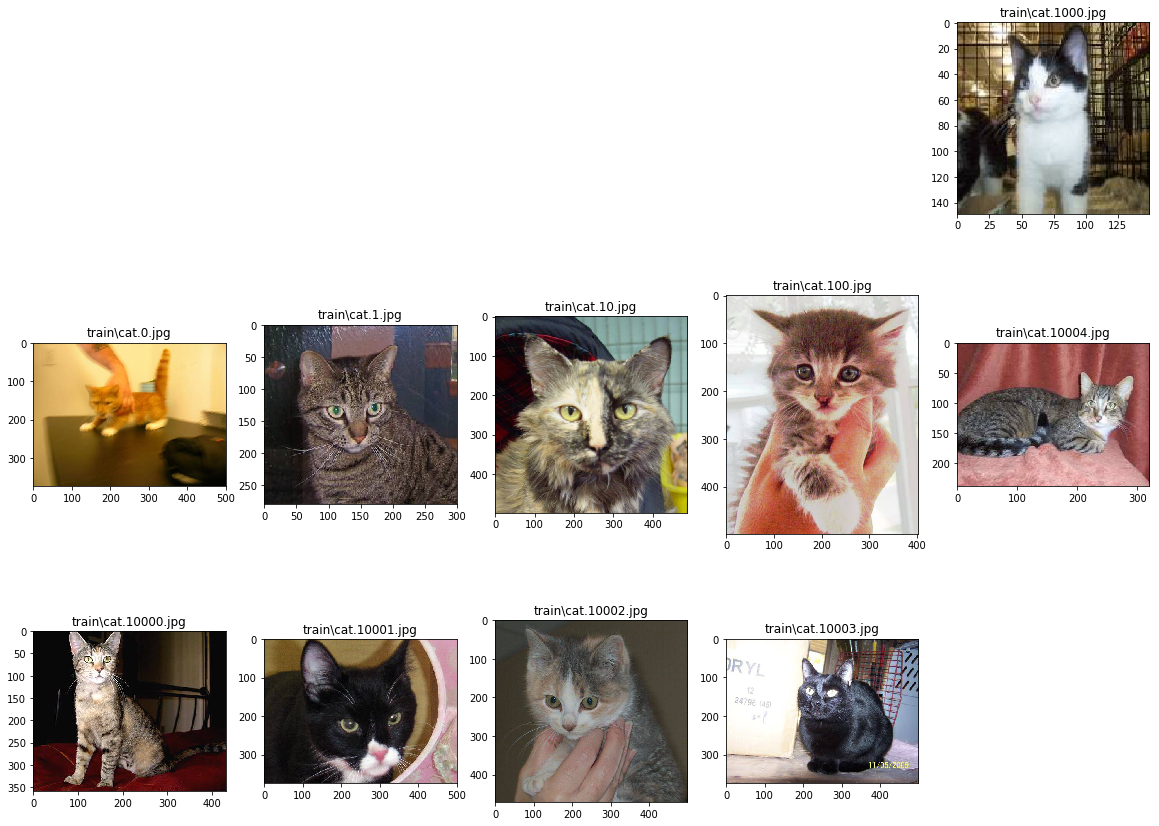

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);
    
plt.show()

In [6]:
loaded_img = load_img(train_files[4], target_size=IMG_SIZE)

## Загружаем предобученную модель

In [7]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [8]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [9]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Добавляем слои

In [10]:
x = base_model.output #layers[-5].output
#x = base_model.layers[-3].output
#x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(128, kernel_size=(5, 5),                #128 5x5              
                              padding='same', 
                              activation='relu')(x)
x = keras.layers.BatchNormalization(axis=1)(x)
x = keras.layers.AveragePooling2D(pool_size=(1, 1), padding='valid')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-5))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Компилируем модель и запускаем обучение

In [12]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [13]:
shuffle(train_files)  # перемешиваем обучающую выборку
train_val_split = 100  # число изображений в валидационной выборке
validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

In [14]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=50,  # число вызовов генератора за эпоху
        epochs=25,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/25
50/50 [==============================] - 10s 196ms/step - loss: 0.2441 - acc: 0.9206 - val_loss: 0.0668 - val_acc: 0.9700
Epoch 2/25
50/50 [==============================] - 8s 160ms/step - loss: 0.0742 - acc: 0.9750 - val_loss: 0.0411 - val_acc: 0.9900
Epoch 3/25
50/50 [==============================] - 8s 160ms/step - loss: 0.0703 - acc: 0.9750 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 4/25
50/50 [==============================] - 8s 160ms/step - loss: 0.0957 - acc: 0.9625 - val_loss: 0.0543 - val_acc: 0.9600
Epoch 5/25
50/50 [==============================] - 8s 160ms/step - loss: 0.0629 - acc: 0.9762 - val_loss: 0.0614 - val_acc: 0.9600
Epoch 6/25
50/50 [==============================] - 8s 160ms/step - loss: 0.0804 - acc: 0.9719 - val_loss: 0.0400 - val_acc: 0.9900
Epoch 7/25
50/50 [==============================] - 8s 161ms/step - loss: 0.0843 - acc: 0.9619 - val_loss: 0.0255 - val_acc: 0.9900
Epoch 8/25
50/50 [==============================] - 8s 161ms/step - loss: 0

In [ ]:
#model.save('')

## Предсказания на проверочной выборке

In [15]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

Wall time: 4min 4s


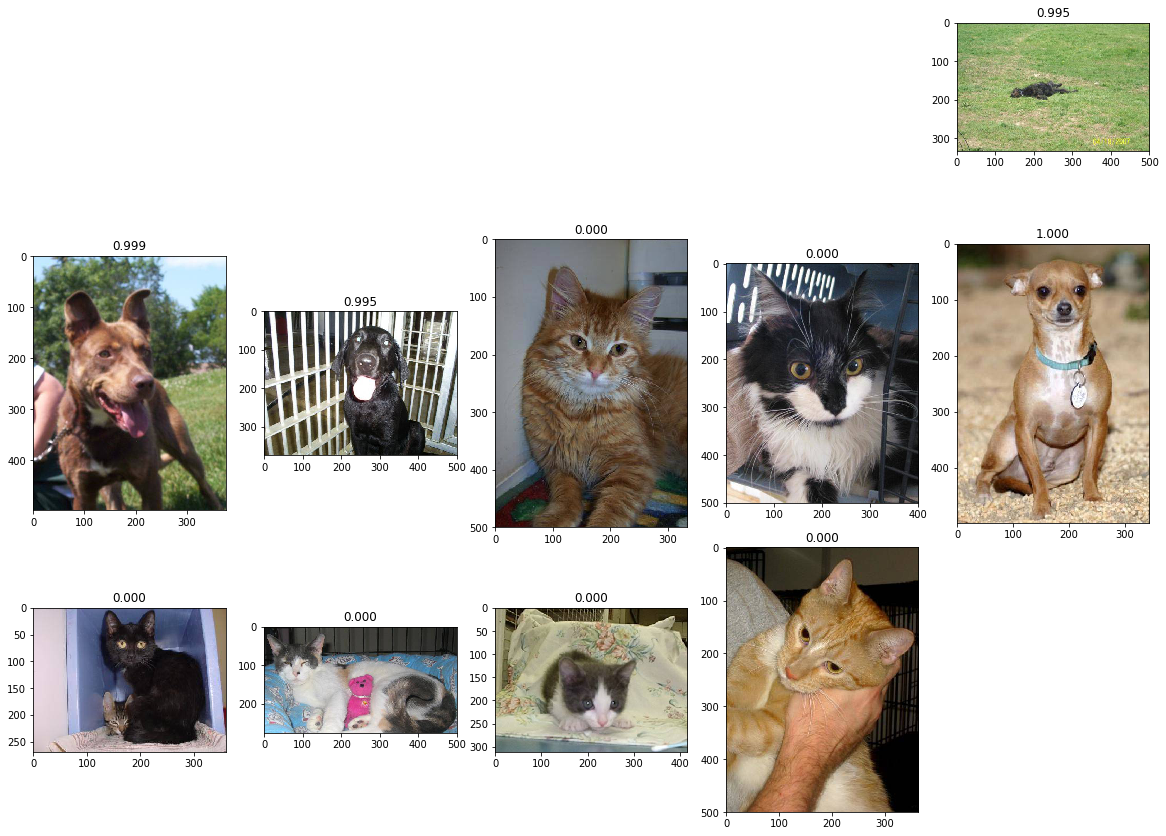

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [17]:
with open('submit_my_net.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [ ]:
# LogLoss = 1.04979